In [10]:
!pip install tensorflow
!pip install pandas openpyxl nltk textblob spacy


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import sentiwordnet as swn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, Embedding, Flatten
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
import spacy

# Download NLTK resources
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

# Load the dataset
df = pd.read_excel('/content/Clift Data.xlsx')

# Initialize NLTK components
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

# Initialize TextBlob for sentiment analysis
def analyze_sentiment(text):
    blob = TextBlob(text)
    sentiment_score = blob.sentiment.polarity

    if sentiment_score > 0.5:
        sentiment_label = "Strongly Positive"
    elif sentiment_score > 0 and sentiment_score <= 0.5:
        sentiment_label = "Weakly Positive"
    elif sentiment_score < -0.5:
        sentiment_label = "Strongly Negative"
    elif sentiment_score < 0 and sentiment_score >= -0.5:
        sentiment_label = "Weakly Negative"
    else:
        sentiment_label = "Strongly Neutral"

    return sentiment_score, sentiment_label

# Convert 'message' column to string type
df['message'] = df['message'].astype(str)

# Load the SpaCy NLP pipeline
nlp = spacy.load("en_core_web_sm")

# Preprocess each message
for i, message in enumerate(df['message']):
    if pd.notna(message):  # Check for NaN values
        # Tokenization
        words = word_tokenize(message)

        # Lemmatization
        lemmatized_words = [lemmatizer.lemmatize(word) for word in words]

        # POS tagging using SpaCy
        doc = nlp(message)
        pos_tags = [(token.text, token.pos_) for token in doc]

        # Sentiment analysis using TextBlob
        sentiment_score, sentiment_label = analyze_sentiment(message)

        # Convert POS tags to a string representation
        pos_tags_str = ' '.join([f"{word}/{tag}" for word, tag in pos_tags])

        # Update dataframe with preprocessed data
        df.loc[i, 'lemmatized_message'] = ' '.join(lemmatized_words)
        df.loc[i, 'pos_tags'] = pos_tags_str
        df.loc[i, 'sentiment_score'] = sentiment_score
        df.loc[i, 'sentiment_label'] = sentiment_label
    else:
        # Handle NaN values in the message column
        df.loc[i, 'lemmatized_message'] = ""
        df.loc[i, 'pos_tags'] = ""
        df.loc[i, 'sentiment_score'] = 0.0
        df.loc[i, 'sentiment_label'] = "Neutral"

# Additional preprocessing steps
df['message'] = df['message'].str.lower()  # Convert to lowercase
df['message'] = df['message'].str.replace('[^a-zA-Z\s]', '')  # Remove special characters
df['message'] = df['message'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))  # Remove stopwords

print("The data has been preprocessed!")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


The data has been preprocessed!


<ipython-input-11-5c723cc91ef0>:87: FutureWarning: The default value of regex will change from True to False in a future version.
  df['message'] = df['message'].str.replace('[^a-zA-Z\s]', '')  # Remove special characters


In [12]:
nltk.download('sentiwordnet')
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split


# Calculate sentiment scores for each sentence using SentiWordNet
def calculate_sentiment_score(sentence):
    tokens = nltk.word_tokenize(sentence)
    pos_score = 0
    neg_score = 0
    for token in tokens:
        synsets = list(swn.senti_synsets(token))
        if synsets:
            synset = synsets[0]  # Consider the first synset
            pos_score += synset.pos_score()
            neg_score += synset.neg_score()
    return pos_score - neg_score

# Define sentiment classes based on sentiment scores
def categorize_sentiment(sentiment_score):
    if sentiment_score > 0.25:
        return "Positive"
    elif sentiment_score < -0.25:
        return "Negative"
    else:
        return "Neutral"

# Apply the sentiment class categorization function to sentiment scores
df['sentiment_label'] = df['sentiment_score'].apply(categorize_sentiment)

# Encode the sentiment labels
label_encoder = LabelEncoder()
df['sentiment_label_encoded'] = label_encoder.fit_transform(df['sentiment_label'])


# Split the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(df['sentiment_score'], df['sentiment_label_encoded'], test_size=0.2, random_state=2)

# Convert labels to categorical form
num_classes = len(label_encoder.classes_)
y_train = to_categorical(y_train, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

# Build the model
model = Sequential()
model.add(Dense(units=128, activation='relu', input_dim=1))  # Assuming your sentiment scores are in 1D array
model.add(Dropout(0.5))
model.add(Dense(units=num_classes, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)


[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/sentiwordnet.zip.


Epoch 1/15
81/81 [==============================] - 6s 8ms/step - loss: 0.8409 - accuracy: 0.9074 - val_loss: 0.5261 - val_accuracy: 0.8796
Epoch 2/15
81/81 [==============================] - 0s 5ms/step - loss: 0.3517 - accuracy: 0.9008 - val_loss: 0.2675 - val_accuracy: 0.8920
Epoch 3/15
81/81 [==============================] - 0s 5ms/step - loss: 0.2190 - accuracy: 0.9244 - val_loss: 0.1793 - val_accuracy: 0.9522
Epoch 4/15
81/81 [==============================] - 0s 4ms/step - loss: 0.1511 - accuracy: 0.9537 - val_loss: 0.1238 - val_accuracy: 0.9660
Epoch 5/15
81/81 [==============================] - 0s 4ms/step - loss: 0.1102 - accuracy: 0.9726 - val_loss: 0.0892 - val_accuracy: 0.9784
Epoch 6/15
81/81 [==============================] - 0s 3ms/step - loss: 0.0881 - accuracy: 0.9784 - val_loss: 0.0682 - val_accuracy: 0.9861
Epoch 7/15
81/81 [==============================] - 0s 3ms/step - loss: 0.0672 - accuracy: 0.9838 - val_loss: 0.0550 - val_accuracy: 0.9861
Epoch 8/15
81/81 [==

21/21 [==============================] - 0s 2ms/step


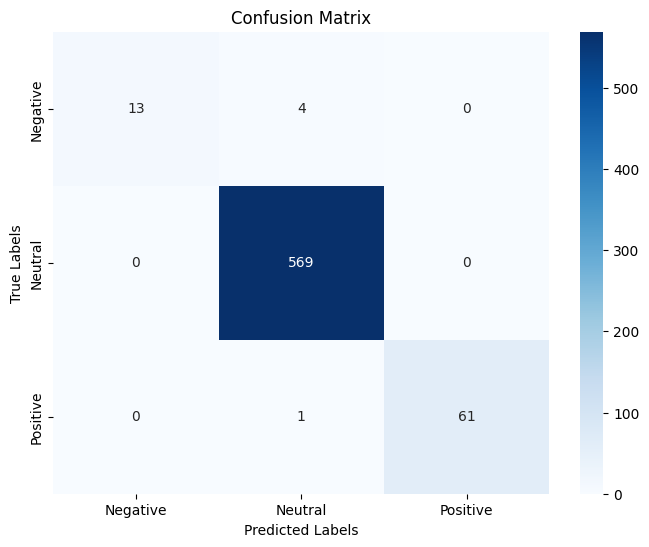

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


# Predict probabilities for each class
y_pred_probs = model.predict(X_test)

# Convert probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=1)

# Decode one-hot encoded labels
y_test_decoded = np.argmax(y_test, axis=1)

# Create a confusion matrix
confusion_mtx = confusion_matrix(y_test_decoded, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# Create a classification report
class_names = label_encoder.classes_
classification_rep = classification_report(y_test_decoded, y_pred, target_names=class_names)

print("Classification Report:\n", classification_rep)

Classification Report:
               precision    recall  f1-score   support

    Negative       1.00      0.76      0.87        17
     Neutral       0.99      1.00      1.00       569
    Positive       1.00      0.98      0.99        62

    accuracy                           0.99       648
   macro avg       1.00      0.92      0.95       648
weighted avg       0.99      0.99      0.99       648



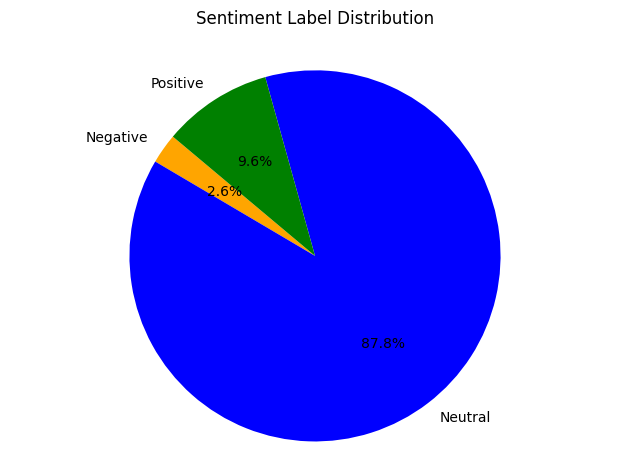

In [31]:
# Calculate class-wise sums from the confusion matrix
class_counts = np.sum(confusion_mtx, axis=1)

# Define custom colors for the pie chart
custom_colors = ['orange', 'blue', 'green']

# Add pie chart
plt.subplot(1, 1, 1)
plt.pie(class_counts, labels=label_encoder.classes_, autopct='%1.1f%%', startangle=140, colors=custom_colors)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Sentiment Label Distribution', pad=20)
plt.tight_layout()
plt.show()

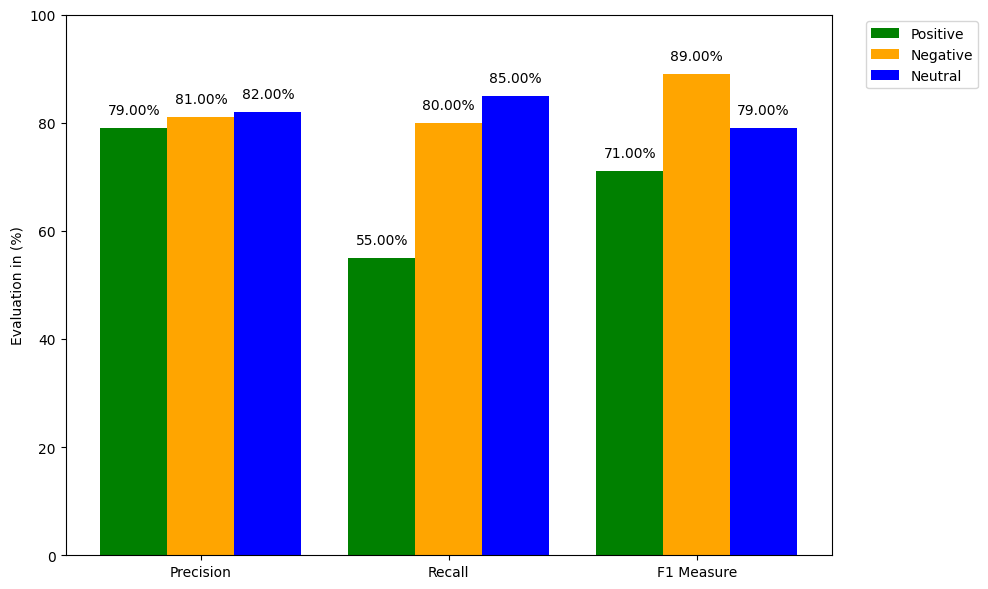

In [1]:
import matplotlib.pyplot as plt
import numpy as np

def create_combined_bar_graph(labels, positive_scores, negative_scores, neutral_scores):
    x = np.arange(len(labels))
    width = 0.27

    plt.figure(figsize=(10, 6))

    plt.bar(x - width, positive_scores, width, label='Positive', color='green')
    plt.bar(x, negative_scores, width, label='Negative', color='orange')
    plt.bar(x + width, neutral_scores, width, label='Neutral', color='blue')

    plt.ylabel('Evaluation in (%)')
    plt.xticks(x, labels)

    # Set y-axis limit to 100
    plt.ylim(0, 100)

    # Place the legend on the outside upper right corner
    plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))

    # Add data values as labels on the bars
    for i, val in enumerate(positive_scores):
        plt.annotate(f'{val:.2f}%', (x[i] - width, val), textcoords="offset points", xytext=(0,10), ha='center')

    for i, val in enumerate(negative_scores):
        plt.annotate(f'{val:.2f}%', (x[i], val), textcoords="offset points", xytext=(0,10), ha='center')

    for i, val in enumerate(neutral_scores):
        plt.annotate(f'{val:.2f}%', (x[i] + width, val), textcoords="offset points", xytext=(0,10), ha='center')

    plt.tight_layout()
    plt.grid(False)
    plt.show()

positive_scores = [79, 55, 71]  # Replace with actual positive scores
negative_scores = [81, 80, 89]  # Replace with actual negative scores
neutral_scores = [82, 85, 79]   # Replace with actual neutral scores

metrics = ['Precision', 'Recall', 'F1 Measure']

# Create the combined bar graph
create_combined_bar_graph(metrics, positive_scores, negative_scores, neutral_scores)


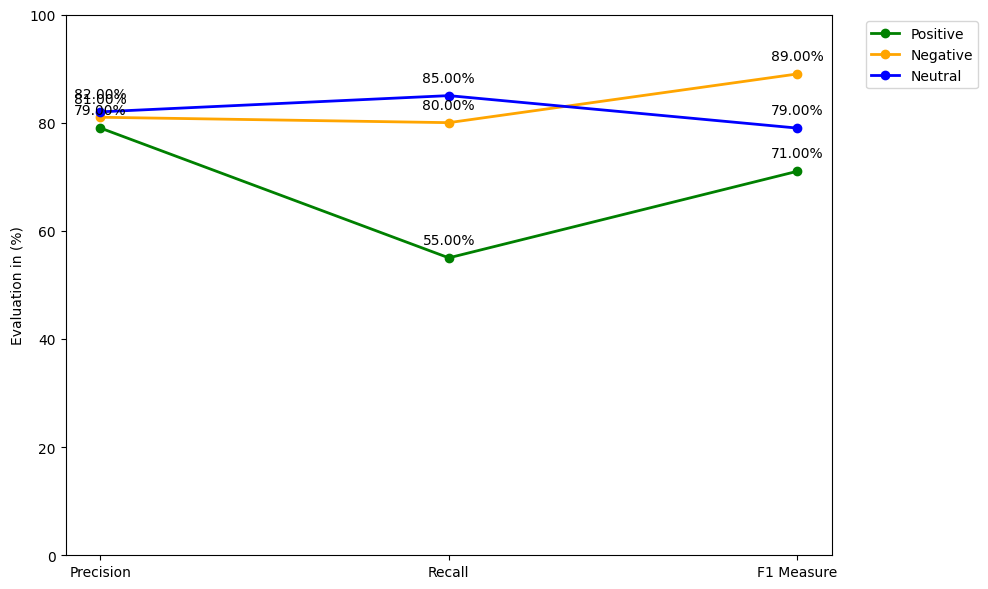

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def create_combined_line_graph(labels, positive_scores, negative_scores, neutral_scores):
    x = np.arange(len(labels))

    plt.figure(figsize=(10, 6))

    plt.plot(x, positive_scores, marker='o', label='Positive', color='green', linewidth=2)
    plt.plot(x, negative_scores, marker='o', label='Negative', color='orange', linewidth=2)
    plt.plot(x, neutral_scores, marker='o', label='Neutral', color='blue', linewidth=2)

    plt.ylabel('Evaluation in (%)')
    plt.xticks(x, labels)

    # Set y-axis limit to 100
    plt.ylim(0, 100)

    # Place the legend on the outside upper right corner
    plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1))

    # Add data values as labels on the points
    for i, val in enumerate(positive_scores):
        plt.annotate(f'{val:.2f}%', (x[i], val), textcoords="offset points", xytext=(0,10), ha='center')

    for i, val in enumerate(negative_scores):
        plt.annotate(f'{val:.2f}%', (x[i], val), textcoords="offset points", xytext=(0,10), ha='center')

    for i, val in enumerate(neutral_scores):
        plt.annotate(f'{val:.2f}%', (x[i], val), textcoords="offset points", xytext=(0,10), ha='center')

    plt.tight_layout()
    plt.grid(False)
    plt.show()

positive_scores = [79, 55, 71]  # Replace with actual positive scores
negative_scores = [81, 80, 89]  # Replace with actual negative scores
neutral_scores = [82, 85, 79]   # Replace with actual neutral scores

metrics = ['Precision', 'Recall', 'F1 Measure']

# Create the combined line graph
create_combined_line_graph(metrics, positive_scores, negative_scores, neutral_scores)


In [27]:
# Export the preprocessed DataFrame to a CSV file
df.to_csv('/content/preprocessed_data.csv', index=False)

print("Preprocessed data has been exported to 'preprocessed_data.csv'!")


Preprocessed data has been exported to 'preprocessed_data.csv'!
